# Regressions

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso, LinearRegression
from scipy.stats import skew
from sklearn import decomposition
import math

plt.style.use('ggplot')

On this step we use the train set to fit severl linear models.

In [2]:
# Load the train set
df = pd.read_csv('./data/new_train.csv')
df.drop(['Unnamed: 0', 'Id'], axis=1, inplace=True)

# Load categorical variables
numerical = pickle.load(open('./tmp/numerical.list', 'rb'))

df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,RoofMatl_WdShngl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,0,1,0,0,1,0,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,1,0,0,0,0,0,0,1
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,0,1,0,0,0,0,1
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,0,0,0,1,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,1,0,0,0,0,0,0,1


## SalePrice vs. Log Sale Price

For regression models we choose whether to use the sales prices or the log of them. Let's look at the distribution of the prices in our dataset.

    price  log(price)
0  208500   12.247694
1  181500   12.109011
2  223500   12.317167
3  140000   11.849398
4  250000   12.429216


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fb1df9fd0>,
      dtype=object)

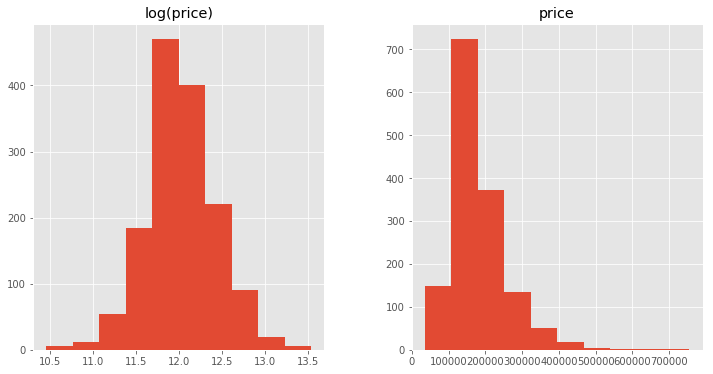

In [3]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
print (prices.head())
prices.hist()

It seems that the prices follow the lognormal distribution. Therefore, we will use log of prices as our response variable.

To illustrate it we plot scatter plots of Sales Price and Living Area

Text(0.5,1,'Price')

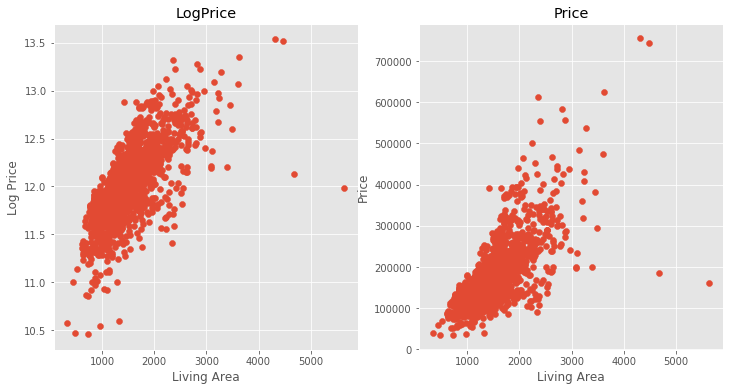

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

We also notice that two houses have an extremely large area with relatively low price. We remove them as outliers

In [5]:
df = df.loc[(df.GrLivArea<4000) & (df.SalePrice<700000),:]

Text(0.5,1,'Price')

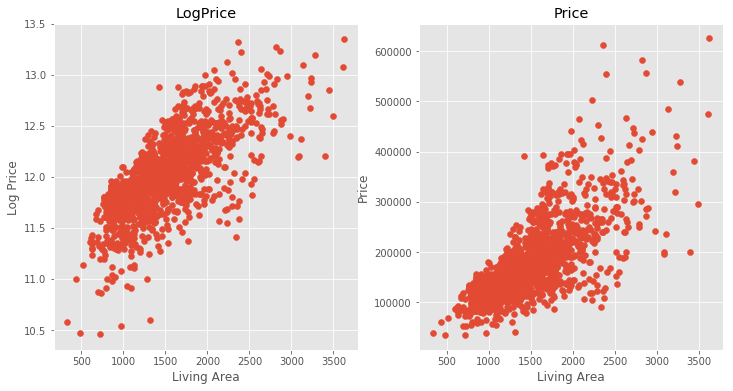

In [6]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Living Area')
plt.title('Price')

## Feature Engeneering

Next, we look at distributions of numerical features and their skeweness.

In [7]:
skewed_feats = df[numerical].apply(lambda x: skew(x)) # compute skewness

skewed_feats.drop('SalePrice', axis=0, inplace=True)

# Select where skewenes is >0.75
skewed_feats = skewed_feats[skewed_feats>0.75]

# Get names of skewed features
sk_feat = list(skewed_feats.index.values)
skewed_feats

3SsnPorch        10.279262
BsmtUnfSF         0.920809
WoodDeckSF        1.549672
BsmtFinSF2        4.244209
LotArea          12.574590
ScreenPorch       4.111400
LaborForce        1.206977
MasVnrArea        2.654761
2ndFlrSF          0.777065
LotFrontage       1.535840
BsmtHalfBath      4.124712
EnclosedPorch     3.081275
PoolArea         17.504556
KitchenAbvGr      4.476748
1stFlrSF          0.866187
MiscVal          24.418175
OpenPorchSF       2.337435
LowQualFinSF      8.989291
GrLivArea         0.834332
dtype: float64

In [8]:
# Save initial values for comparison
init_skewed = df[sk_feat]

# Apply Log+1 transformation
df[sk_feat] = np.log1p(df[sk_feat])

Plot new features histograms

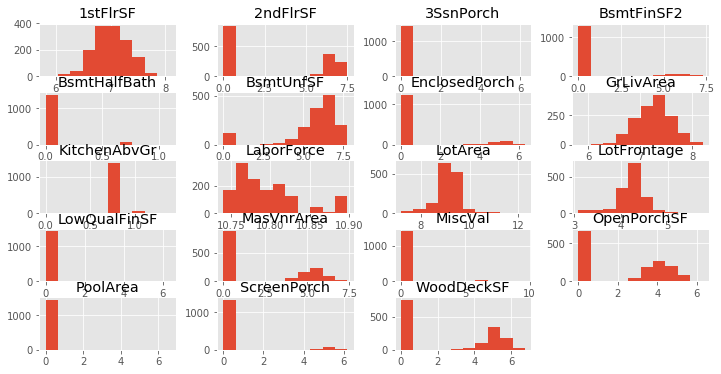

In [9]:
# Calculate skewenes
_ = df[sk_feat].hist()

For illistration, we plot the same scatter plots but using transformed living space variable.

Text(0.5,1,'Price')

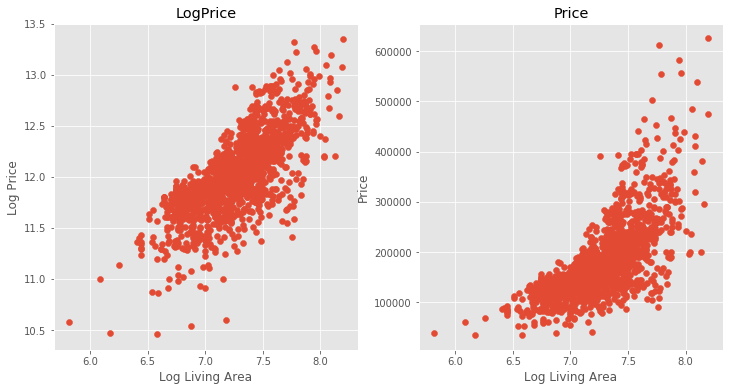

In [10]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":df["SalePrice"], "log(price)":np.log(df["SalePrice"])})
prices = prices.join(pd.DataFrame({'LivingArea':df.GrLivArea}))

plt.subplot(1,2,1)
plt.scatter(prices['LivingArea'], prices['log(price)'])
plt.ylabel('Log Price')
plt.xlabel('Log Living Area')
plt.title('LogPrice')

plt.subplot(1,2,2)
plt.scatter(prices['LivingArea'], prices['price'])
plt.ylabel('Price')
plt.xlabel('Log Living Area')
plt.title('Price')

In [11]:
# Save skewed features list
pickle.dump(sk_feat, open('./tmp/sk_feat.list', 'wb'))

## Models fitted to the whole features set

First, we fit linear regression models to the whole dataset.

## Model 1: Linear regression on the whole set

In [12]:
data = df.copy()

# Create sets
X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])

X.shape

(1456, 278)

In [13]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 278)
X_test : (437, 278)
y_train : (1019,)
y_test : (437,)


We create helper functions to evaluate results

In [14]:
def rmse_cv(model, X, y):
    '''
    A helper function to calculate the cross validated RMSE
    '''
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

In [15]:
def rmsle(model, X, y):
    '''
    Calculates rmsle as set by Kaggle
    '''
    return (math.sqrt(np.mean((np.log10(np.exp(model.predict(X))) - np.log10(np.exp(y))) ** 2)))

### Model 1a: Ridge normalization

Lowest rmse:  0.11693616365651267
Optimal alpha:  [7.9]


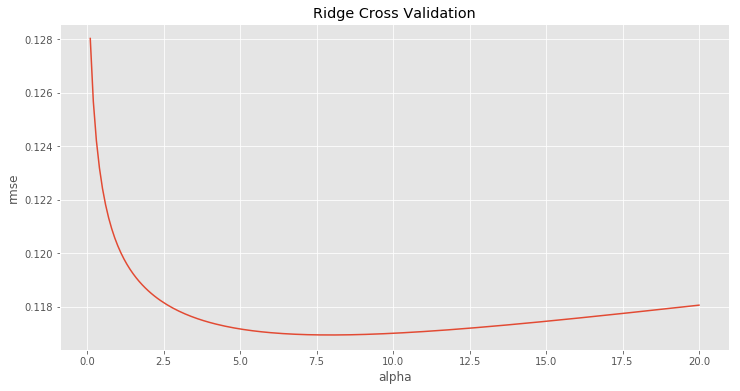

In [16]:

alphas = np.linspace(0.1,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.041632036359492794
Model test accuracy (rmsle):  0.04742654904054274


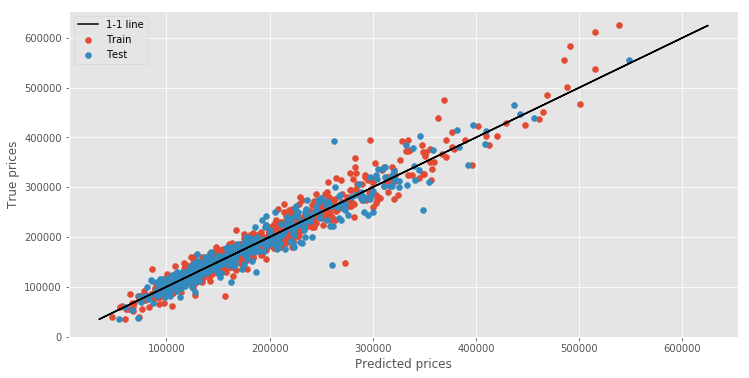

In [17]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test, y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [18]:
model1a = Ridge(alpha=alpha)
model1a.fit(X,y)

score1a = rmsle(model1a, X, y)

print('Model accuracy rmsle: ', rmsle(model1a, X, y))

Model accuracy rmsle:  0.04181179062815433


We plot regression coefficients

<BarContainer object of 20 artists>

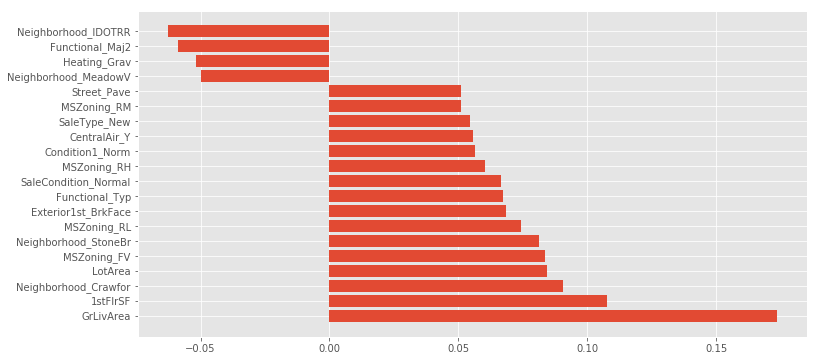

In [19]:
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

### Model 1b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy train : 0.1165434596543724
Model accuracy test: 0.12818522784651465


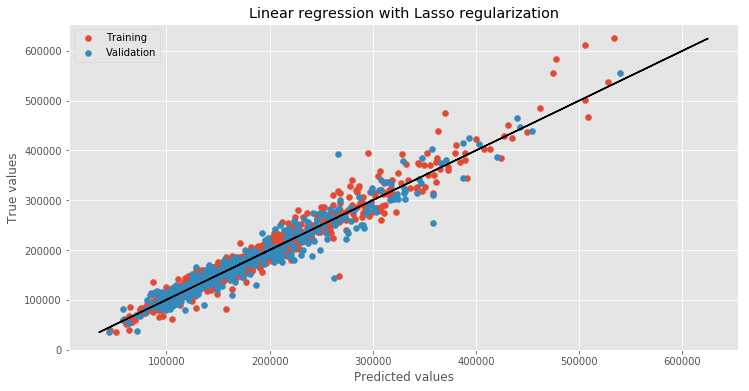

In [20]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/figX.png', dpi=300)
plt.show()




In [21]:
model1b = Lasso(alpha=alpha)
model1b.fit(X,y)

score1b =  rmsle(model1b, X, y)

print('Model accuracy rmsle: ', rmsle(model1b, X, y))

Model accuracy rmsle:  0.040537044465371264


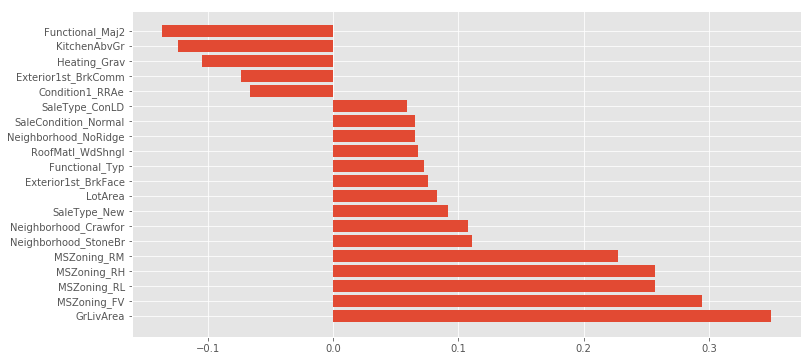

In [22]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X.columns.values, 'Coefficient':model1b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


Train model on the whole dataset.

## Fitting the model on the selected features

The features that were selected in [Trees.ipynb](Trees.ipynb) are used to create regression models

In [23]:
# Load list of variables
select_var = pickle.load(open('./tmp/feaure_list_dt.list', 'rb'))

# Set new X
X_sel = X[select_var].copy()

### Model 2a: Ridge regularization

In [24]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 23)
X_test : (437, 23)
y_train : (1019,)
y_test : (437,)


Lowest rmse:  0.1326626595213423
Optimal alpha:  [0.8]


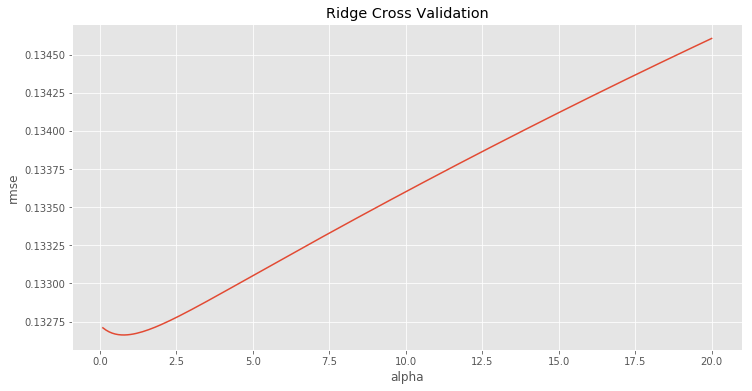

In [25]:

alphas = np.linspace(0.1,20,200)
cv_ridge = [rmse_cv(Ridge(alpha = alpha), X_train,y_train).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Ridge Cross Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")


print('Lowest rmse: ',cv_ridge.min())
print('Optimal alpha: ', cv_ridge[cv_ridge==cv_ridge.min()].index.values)

alpha = cv_ridge[cv_ridge==cv_ridge.min()].index.values

Fit model to the new train dataset and compare with new test.

Model train accuracy (rmsle):  0.05601329357389487
Model test accuracy (rmsle):  0.04990944581884754


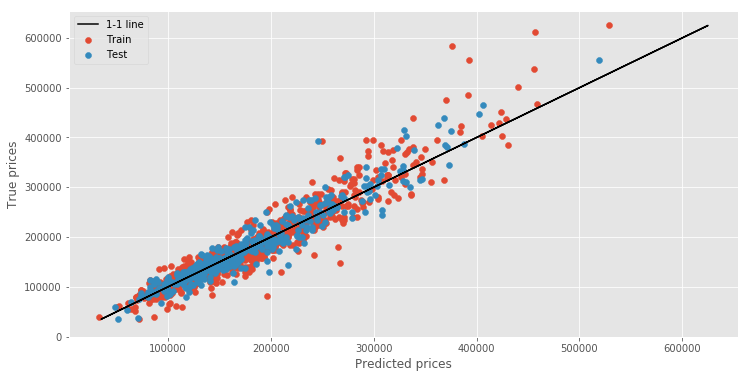

In [26]:
model_tmp = Ridge(alpha=alpha)
model_tmp = model_tmp.fit(X_train,y_train)

print('Model train accuracy (rmsle): ', rmsle(model_tmp, X_train, y_train))
print('Model test accuracy (rmsle): ', rmsle(model_tmp, X_test,y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_ = plt.legend()


We train the model on the whole dataset

In [27]:
model2a = Ridge(alpha=alpha)
model2a.fit(X_sel,y)

score2a = rmsle(model2a, X_sel, y)

print('Model accuracy (rmsle): ', rmsle(model2a, X_sel, y))

Model accuracy (rmsle):  0.05406626082009621


We plot regression coefficients

<BarContainer object of 20 artists>

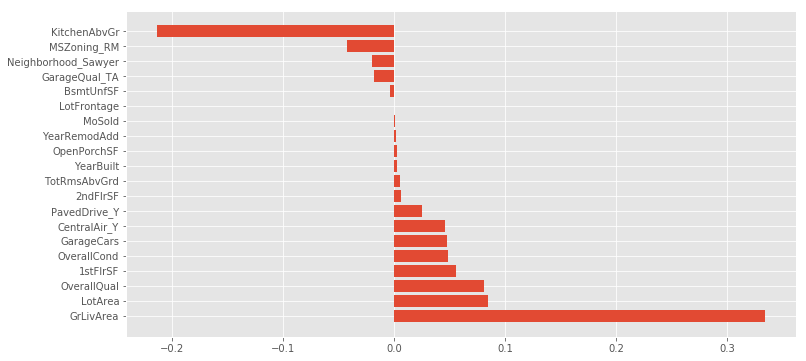

In [29]:
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2a.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)

## Model 2b: LASSO regularization 

Alpha : 0.00015000000000000001
Model accuracy (rmse) train : 0.13267927828977694
Model accuracy (rmse) test: 0.11579088029486821


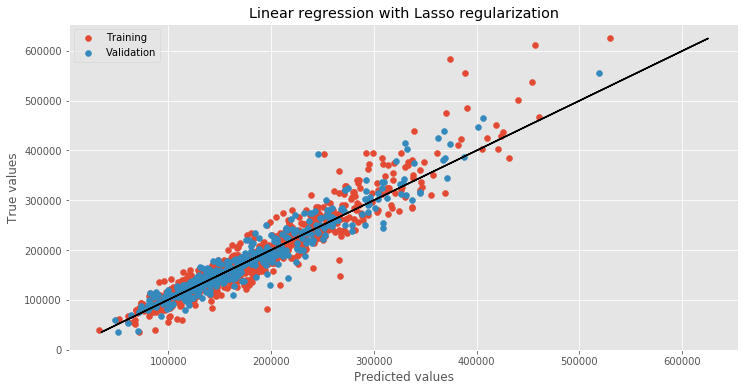

In [30]:
alphas = np.linspace(0.0001,1,20)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_


# Narrow down alpha
alphas = alpha * np.linspace(0.5, 1.5, 10)

lasso = LassoCV(alphas = alphas, 
                max_iter = 50000, cv = 10)

# Fit the model
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Alpha :", alpha)

print("Model accuracy (rmse) train :", rmse_cv(lasso, X_train, y_train).mean())
print("Model accuracy (rmse) test:", rmse_cv(lasso, X_test, y_test).mean())
y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)


# Plot predictions
plt.scatter(np.exp(y_train_las), np.exp(y_train), label = "Training")
plt.scatter(np.exp(y_test_las), np.exp(y_test), label = "Validation")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.legend()
plt.plot(np.exp(y), np.exp(y), c = "black")
plt.savefig('./output/figX.png', dpi=300)
plt.show()




In [31]:
model2b = Lasso(alpha=alpha)
model2b.fit(X_sel,y)

score2b = rmsle(model2b, X_sel, y)

print('Model accuracy (rmsle): ', rmsle(model2b, X_sel, y))

Model accuracy (rmsle):  0.054064732134824704


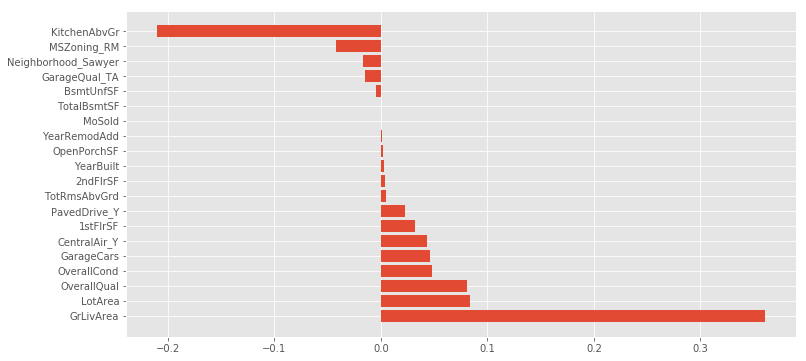

In [32]:
# Plot important coefficients
coefs = pd.DataFrame({'Feature':X_sel.columns.values, 'Coefficient':model2b.coef_})

# Plot the most important features
coefs['sort'] = coefs.Coefficient.abs()
coefs = coefs.sort_values('sort', ascending=False).drop('sort', axis=1).head(20).sort_values('Coefficient', ascending=False)
plt.barh(coefs.Feature, coefs.Coefficient)
plt.savefig('./output/figX.png', dpi=300)
plt.show()


## PCA models

We perform a principal component analysis and fit regressions to principal components.

In [41]:
data = df.copy()

X = data.copy().drop('SalePrice', axis=1)
y = np.log(data.copy()['SalePrice'])
print(X.shape)

# Cross validate PCA
n_folds = 10
n_sim = 10
n_comp = np.linspace(1,100,100, dtype=int)

result = np.zeros(len(n_comp)*2).reshape(len(n_comp),2)

# Perform naive cross-validation
for n, comp in enumerate(n_comp):
    train = 0.0
    test = 0.0            
    for i in range(0,n_sim):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/n_folds)
        pca = decomposition.PCA(n_components=comp)
        pca.fit(X_train)
        transformed_train = pca.transform(X_train)
        model_tmp= LinearRegression()
        
        score_train = model_tmp.fit(transformed_train, y_train)
        score_train = score_train.score(transformed_train, y_train)
        train += score_train

        transformed_test = pca.transform(X_test)
        score_test = model_tmp.fit(transformed_test, y_test)
        score_test = score_test.score(transformed_test, y_test)
        test += score_test

    result[n,0]= train/n_sim
    result[n,1] = test/n_sim



(1456, 278)


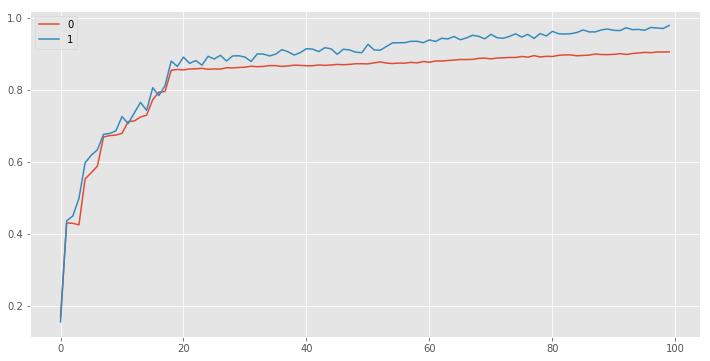

In [149]:
pd.DataFrame(result).plot()

In [152]:
pd.DataFrame(result, columns=['train', 'test']).head(30)

,train,test
0,0.167917,0.154114
1,0.429836,0.435664
2,0.428963,0.449325
3,0.424687,0.498556
4,0.552675,0.597765
5,0.569893,0.618527
6,0.588350,0.633859
7,0.669480,0.676703
8,0.673279,0.679346
9,0.674645,0.686282


We keep four principal components

In [34]:

pca = decomposition.PCA(n_components=18)
pca.fit(X)
transformed = pca.transform(X)

explained_variance = np.var(transformed, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

# Find how may components explain 98% of variance
expl = np.cumsum(explained_variance_ratio)
expl


array([0.47510617, 0.77570558, 0.9277482 , 0.9629739 , 0.99592684,
       0.99830916, 0.99957395, 0.99992867, 0.99994697, 0.999958  ,
       0.99996756, 0.99997636, 0.99998259, 0.99998787, 0.99999192,
       0.99999481, 0.99999746, 1.        ])

In [35]:
X_pca = pd.DataFrame(transformed)
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,131.184701,-48.013607,-329.184138,77.927720,21.122280,-14.561178,-35.555119,1.617924,3.424980,-4.966106,-2.851017,1.560365,0.826685,-0.475729,0.437326,-0.699651,-0.140392,0.041471
1,486.626377,237.539296,-218.040544,-55.015446,-137.600764,-56.400703,0.131694,-6.898895,-1.648597,0.115186,3.500840,-1.731609,-2.051000,1.575795,-1.083994,-0.190290,-0.223027,0.259087
2,56.192167,-141.817417,-130.347735,119.244567,42.361733,-15.562516,-29.123802,0.518902,3.157739,1.985965,-4.081762,1.138386,0.684258,0.200186,0.470508,0.155157,-1.507024,-0.229710
3,-189.958189,-324.047222,-65.189424,226.577672,-138.781065,32.928020,62.788905,14.279660,1.639389,-5.776555,-0.645792,-1.282092,-0.949051,-1.138578,3.538790,1.125705,0.200598,-0.339373
4,343.363451,-24.245269,-52.132771,274.784965,122.258313,67.047681,-3.578583,-1.439092,5.121520,4.539691,0.092336,1.496943,-0.262500,-0.045075,0.389074,-0.248059,-0.374434,0.196689


### Model 3: Multiple Linear Regression

In [36]:
# Divide the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1019, 18)
X_test : (437, 18)
y_train : (1019,)
y_test : (437,)


Model train accuracy (mrsle):  0.07350801263150113
Model test accuracy (mrsle):  0.07121339935610622


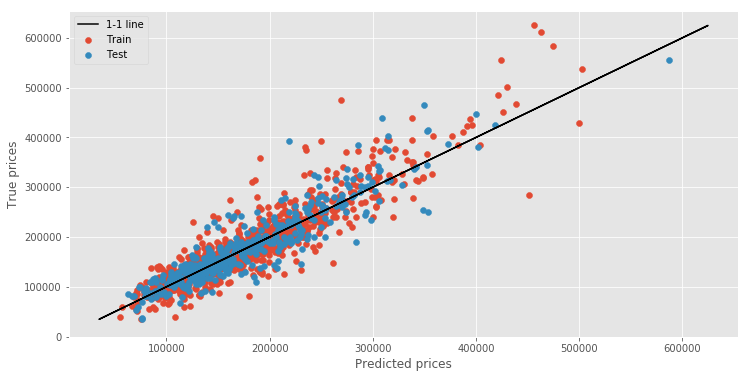

In [37]:

model_tmp= LinearRegression()
model_tmp = model_tmp.fit(X_train, y_train)


print('Model train accuracy (mrsle): ', rmsle(model_tmp, X_train,y_train))
print('Model test accuracy (mrsle): ', rmsle(model_tmp, X_test,y_test))

plt.scatter(np.exp(model_tmp.predict(X_train)), np.exp(y_train), label='Train')
plt.scatter(np.exp(model_tmp.predict(X_test)), np.exp(y_test), label='Test')
plt.plot(np.exp(y), np.exp(y), c='black', label = '1-1 line')
plt.xlabel('Predicted prices')
plt.ylabel('True prices')
_  = plt.legend()

Fit to the whole dataset

In [38]:
model3= LinearRegression()

model3.fit(X_pca, y)

score3 = rmsle(model3, X_pca, y)

print('Model accuracy (rmsle): ', rmsle(model3, X_pca, y))


Model accuracy (rmsle):  0.07253964653585115


## Combine the models

We combine the models and pickle them for use on the train set

In [39]:
# Models

models = ['model1a', 'model1b', 'model2a', 'model2b', 'model3']
scores = [score1a, score1b, score2a, score2b, score3]

models_comb = pd.DataFrame({'model':models, 'score': scores})
print(models_comb)

# Pickle
pickle.dump(models_comb, open('./tmp/models_comb', 'wb'))

     model     score
0  model1a  0.041812
1  model1b  0.040537
2  model2a  0.054066
3  model2b  0.054065
4   model3  0.072540


Pickle models

In [40]:
models_obj = [model1a, model1b, model2a, model2b, model3]

for i, model in enumerate(models_obj):
    name = './tmp/'+models[i]+'.model'
    pickle.dump(model, open(name, 'wb'))
